# **Setup**

In [2]:
!pip install git+https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch
!pip install git+https://github.com/openai/glide-text2im
!pip install folium==0.2.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch to /tmp/pip-req-build-s5fv6bc9
  Running command git clone -q https://github.com/energy-based-model/Compositional-Visual-Generation-with-Composable-Diffusion-Models-PyTorch /tmp/pip-req-build-s5fv6bc9
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/glide-text2im to /tmp/pip-req-build-lqmcchmv
  Running command git clone -q https://github.com/openai/glide-text2im /tmp/pip-req-build-lqmcchmv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Compose Language Descriptions using pretrained GLIDE**

In [ ]:
from PIL import Image
from IPython.display import display
import torch as th

from glide_text2im.download import load_checkpoint
from glide_text2im.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)


In [ ]:
# This notebook supports both CPU and GPU.
# On CPU, generating one sample may take on the order of 20 minutes.
# On a GPU, it should be under a minute.

has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

In [ ]:
# Create base model.
timestep_respacing =  100 #@param{type: 'number'}
options = model_and_diffusion_defaults()
options['use_fp16'] = has_cuda
options['timestep_respacing'] = str(timestep_respacing) # use 100 diffusion steps for fast sampling
model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(load_checkpoint('base', device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

total base parameters 385030726


In [ ]:
# Create upsampler model.
options_up = model_and_diffusion_defaults_upsampler()
options_up['use_fp16'] = has_cuda
options_up['timestep_respacing'] = 'fast27' # use 27 diffusion steps for very fast sampling
model_up, diffusion_up = create_model_and_diffusion(**options_up)
model_up.eval()
if has_cuda:
    model_up.convert_to_fp16()
model_up.to(device)
model_up.load_state_dict(load_checkpoint('upsample', device))
print('total upsampler parameters', sum(x.numel() for x in model_up.parameters()))

total upsampler parameters 398361286


In [5]:
def show_images(batch: th.Tensor):
    """ Display a batch of images inline. """
    scaled = ((batch + 1)*127.5).round().clamp(0,255).to(th.uint8).cpu()
    reshaped = scaled.permute(2, 0, 3, 1).reshape([batch.shape[2], -1, 3])
    display(Image.fromarray(reshaped.numpy()))

In [ ]:
# Sampling parameters
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.
prompt = "a camel | a forest" #@param{type: 'string'}
prompts = [x.strip() for x in prompt.split('|')]
print(prompts)
batch_size = 1
guidance_scale = 10 #@param{type: 'number'}
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.980 #@param{type: 'number'}

['a camel', 'a forest']


In [ ]:
masks = [True] * len(prompts) + [False]
# coefficients = th.tensor([0.5, 0.5], device=device).reshape(-1, 1, 1, 1)
masks = th.tensor(masks, dtype=th.bool, device=device)
# sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[:1]
    combined = th.cat([half] * x_t.size(0), dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps = eps[masks].mean(dim=0, keepdim=True)
    # cond_eps = (coefficients * eps[masks]).sum(dim=0)[None]
    uncond_eps = eps[~masks].mean(dim=0, keepdim=True)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps] * x_t.size(0), dim=0)
    return th.cat([eps, rest], dim=1)

In [ ]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
def sample_64(prompts):
  tokens_list = [model.tokenizer.encode(prompt) for prompt in prompts]
  outputs = [model.tokenizer.padded_tokens_and_mask(
      tokens, options['text_ctx']
  ) for tokens in tokens_list]

  cond_tokens, cond_masks = zip(*outputs)
  cond_tokens, cond_masks = list(cond_tokens), list(cond_masks)

  full_batch_size = batch_size * (len(prompts) + 1)
  uncond_tokens, uncond_mask = model.tokenizer.padded_tokens_and_mask(
      [], options['text_ctx']
  )

  # Pack the tokens together into model kwargs.
  model_kwargs = dict(
      tokens=th.tensor(
          cond_tokens + [uncond_tokens], device=device
      ),
      mask=th.tensor(
          cond_masks + [uncond_mask],
          dtype=th.bool,
          device=device,
      ),
  )
  
  # Sample from the base model.
  model.del_cache()
  samples = diffusion.p_sample_loop(
      model_fn,
      (full_batch_size, 3, options["image_size"], options["image_size"]),
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model.del_cache()

  # Show the output
  return samples

  0%|          | 0/100 [00:00<?, ?it/s]

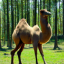

In [ ]:
# sampling 64x64 images
samples = sample_64(prompts)
show_images(samples)

In [ ]:
##############################
# Upsample the 64x64 samples #
##############################

def upsampling_256(prompts, samples):
  tokens = model_up.tokenizer.encode("".join(prompts))
  tokens, mask = model_up.tokenizer.padded_tokens_and_mask(
      tokens, options_up['text_ctx']
  )

  # Create the model conditioning dict.
  model_kwargs = dict(
      # Low-res image to upsample.
      low_res=((samples+1)*127.5).round()/127.5 - 1,

      # Text tokens
      tokens=th.tensor(
          [tokens] * batch_size, device=device
      ),
      mask=th.tensor(
          [mask] * batch_size,
          dtype=th.bool,
          device=device,
      ),
  )

  # Sample from the base model.
  model_up.del_cache()
  up_shape = (batch_size, 3, options_up["image_size"], options_up["image_size"])
  up_samples = diffusion_up.ddim_sample_loop(
      model_up,
      up_shape,
      noise=th.randn(up_shape, device=device) * upsample_temp,
      device=device,
      clip_denoised=True,
      progress=True,
      model_kwargs=model_kwargs,
      cond_fn=None,
  )[:batch_size]
  model_up.del_cache()

  # Show the output
  return up_samples

  0%|          | 0/27 [00:00<?, ?it/s]

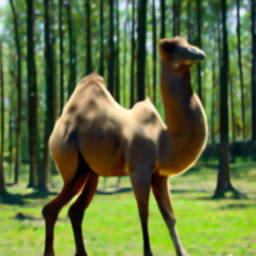

In [ ]:
# upsample from 64x64 to 256x256
upsamples = upsampling_256(prompts, samples)
show_images(upsamples)

In [ ]:
# Sampling parameters
#@markdown `prompt`: when composing  multiple sentences, using `|` as the delimiter.
prompt = "A cloudy blue sky  | A mountain in the horizon | Cherry Blossoms in front of the mountain" #@param{type: 'string'}
prompts = [x.strip() for x in prompt.split('|')]
print(prompts)
batch_size = 1
guidance_scale = 10 #@param{type: 'number'}
# Tune this parameter to control the sharpness of 256x256 images.
# A value of 1.0 is sharper, but sometimes results in grainy artifacts.
upsample_temp = 0.980 #@param{type: 'number'}

['A cloudy blue sky', 'A mountain in the horizon', 'Cherry Blossoms in front of the mountain']


In [ ]:
masks = [True] * len(prompts) + [False]
# coefficients = th.tensor([0.5, 0.5], device=device).reshape(-1, 1, 1, 1)
masks = th.tensor(masks, dtype=th.bool, device=device)
# sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[:1]
    combined = th.cat([half] * x_t.size(0), dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    cond_eps = eps[masks].mean(dim=0, keepdim=True)
    # cond_eps = (coefficients * eps[masks]).sum(dim=0)[None]
    uncond_eps = eps[~masks].mean(dim=0, keepdim=True)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps] * x_t.size(0), dim=0)
    return th.cat([eps, rest], dim=1)

  0%|          | 0/100 [00:00<?, ?it/s]

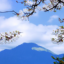

In [ ]:
samples = sample_64(prompts)
show_images(samples)

  0%|          | 0/27 [00:00<?, ?it/s]

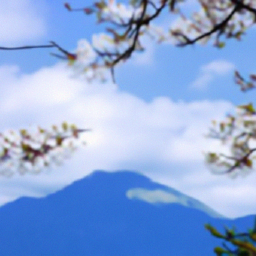

In [ ]:
# upsample from 64x64 to 256x256
upsamples = upsampling_256(prompts, samples)
show_images(upsamples)

# **Compose CLEVR Object at given 2D coordinates**

In [3]:
from PIL import Image
from IPython.display import display
import torch as th

from composable_diffusion.download import download_model
from composable_diffusion.model_creation import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
    model_and_diffusion_defaults_upsampler
)

In [4]:
has_cuda = th.cuda.is_available()
device = th.device('cpu' if not has_cuda else 'cuda')

# Create base model.
timestep_respacing =  100 #@param{type: 'number'}
options = model_and_diffusion_defaults()

flags = {
    "image_size": 128,
    "num_channels": 192,
    "num_res_blocks": 2,
    "learn_sigma": True,
    "use_scale_shift_norm": False,
    "raw_unet": True,
    "noise_schedule": "squaredcos_cap_v2",
    "rescale_learned_sigmas": False,
    "rescale_timesteps": False,
    "num_classes": '2',
    "dataset": "clevr_pos",
    "use_fp16": has_cuda,
    "timestep_respacing": str(timestep_respacing)
}

for key, val in flags.items():
  options[key] = val

model, diffusion = create_model_and_diffusion(**options)
model.eval()
if has_cuda:
    model.convert_to_fp16()
model.to(device)
model.load_state_dict(th.load(download_model('clevr_pos'), device))
print('total base parameters', sum(x.numel() for x in model.parameters()))

  0%|          | 0.00/899M [00:00<?, ?iB/s]

total base parameters 224779782


In [8]:
# Sampling parameters
#@markdown `coordinates`: when composing  multiple positions, using `|` as the delimiter.
#@markdown Note: we use `x` in range `[0.1, 0.9]` and `y` in range `[0.25, 0.7]` since the training dataset labels are in given ranges.

coordinates = "0.1, 0.5 | 0.3, 0.5 | 0.5, 0.5 | 0.7, 0.5 | 0.9, 0.5" #@param{type: 'string'}
coordinates = [[float(x.split(',')[0].strip()), float(x.split(',')[1].strip())] 
               for x in coordinates.split('|')]
print(coordinates)
coordinates += [[-1, -1]] # add unconditional score label
batch_size = 1
guidance_scale = 10 #@param{type: 'number'}

[[0.1, 0.5], [0.3, 0.5], [0.5, 0.5], [0.7, 0.5], [0.9, 0.5]]


In [9]:
# sampling function
def model_fn(x_t, ts, **kwargs):
    half = x_t[:1]
    combined = th.cat([half] * kwargs['y'].size(0), dim=0)
    model_out = model(combined, ts, **kwargs)
    eps, rest = model_out[:, :3], model_out[:, 3:]
    masks = kwargs.get('masks')
    cond_eps = eps[masks].mean(dim=0, keepdim=True)
    uncond_eps = eps[~masks].mean(dim=0, keepdim=True)
    half_eps = uncond_eps + guidance_scale * (cond_eps - uncond_eps)
    eps = th.cat([half_eps] * x_t.size(0), dim=0)
    return th.cat([eps, rest], dim=1)

In [10]:
masks = [True] * (len(coordinates) - 1) + [False]
model_kwargs = dict(
    y=th.tensor(coordinates, dtype=th.float, device=device),
    masks=th.tensor(masks, dtype=th.bool, device=device)
)

In [11]:
##############################
# Sample from the base model #
##############################

# Create the text tokens to feed to the model.
def sample(coordinates):
  samples = diffusion.p_sample_loop(
        model_fn,
        (len(coordinates), 3, options["image_size"], options["image_size"]),
        device=device,
        clip_denoised=True,
        progress=True,
        model_kwargs=model_kwargs,
        cond_fn=None,
    )[:batch_size]
  
  # Show the output
  return samples

  0%|          | 0/100 [00:00<?, ?it/s]

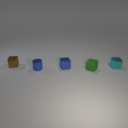

In [13]:
# sampling 128x128 images
samples = sample(coordinates)
show_images(samples)